In [45]:
### Amino acids

In [33]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import json

data_file_path = "/content/drive/MyDrive/protein_props/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/druggable_proteins.txt"
approved_druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/approved_druggable_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))


Total number of uniprot human verified proteins: 20434


In [35]:
with open(druggable_proteins_file_path, 'r') as f:
    druggable_proteins = f.read().splitlines()

with open(approved_druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of approved druggable proteins:", len(approved_druggable_proteins))

Number of druggable proteins: 3345
Number of approved druggable proteins: 2652


In [36]:
max_seq_length = -1
min_seq_length = 1e10

for protein in protein_data:
  seq_length = len(protein_data[protein]['Sequence'])
  max_seq_length = max(max_seq_length, seq_length)
  min_seq_length = min(min_seq_length, seq_length)

print("Maximum Sequence Length:", max_seq_length)
print("Minimum Sequence Length:", min_seq_length)

Maximum Sequence Length: 34350
Minimum Sequence Length: 2


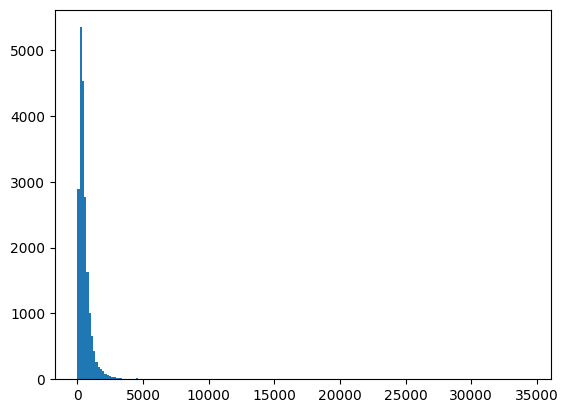

In [37]:
# Distribution of sequence lengths, plot a histogram

import matplotlib.pyplot as plt

plt.hist([len(protein_data[protein]['Sequence']) for protein in protein_data], bins=200)
plt.show()

In [38]:
def find_num_proteins_between(MIN_LENGTH, MAX_LENGTH):
  druggable_protein_count = 0
  non_druggable_protein_count = 0
  for protein in protein_data:
    if MIN_LENGTH <= len(protein_data[protein]['Sequence']) <= MAX_LENGTH:
      if protein in druggable_proteins:
        druggable_protein_count += 1
      else:
        non_druggable_protein_count += 1
  print("Number of proteins between", MIN_LENGTH, "and", MAX_LENGTH, ":", druggable_protein_count + non_druggable_protein_count)
  print("Number of druggable proteins between", MIN_LENGTH, "and", MAX_LENGTH, ":", druggable_protein_count)
  print("Number of non-druggable proteins between", MIN_LENGTH, "and", MAX_LENGTH, ":", non_druggable_protein_count)

In [39]:
find_num_proteins_between(100, 500)

Number of proteins between 100 and 500 : 11632
Number of druggable proteins between 100 and 500 : 1859
Number of non-druggable proteins between 100 and 500 : 9773


In [40]:
# Find unique amino acids in protein sequences
unique_amino_acids = set()
for protein in protein_data:
    seq = protein_data[protein]['Sequence']
    for aa in seq:
        unique_amino_acids.add(aa)

print("Number of unique amino acids:", len(unique_amino_acids))
print(unique_amino_acids)

Number of unique amino acids: 20
{'M', 'Y', 'D', 'G', 'E', 'Q', 'T', 'F', 'L', 'C', 'W', 'P', 'N', 'K', 'A', 'S', 'V', 'I', 'R', 'H'}


In [41]:
unique_amino_acids = sorted(list(unique_amino_acids))
print(unique_amino_acids)

amino_acid_to_num_mapping = {aa: i+1 for i, aa in enumerate(unique_amino_acids)}
print(amino_acid_to_num_mapping)

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


In [42]:
def get_data_protein_sequence_encoding(MIN_LENGTH, MAX_LENGTH):
  valid_length_proteins = {}
  for protein in protein_data:
    if MIN_LENGTH <= len(protein_data[protein]['Sequence']) <= MAX_LENGTH:
      seq = protein_data[protein]['Sequence']
      encoded_seq = [amino_acid_to_num_mapping[aa] for aa in seq]
      valid_length_proteins[protein] = encoded_seq
  print("Total data length: ", len(valid_length_proteins))
  return valid_length_proteins

In [43]:
protein_data_100_500 = get_data_protein_sequence_encoding(100, 500)

Total data length:  11632


In [66]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

def sequence_process(sequences):
  max_length = max(len(seq) for seq in sequences)
  processed_sequences = []
  for seq in sequences:
    while len(seq) < max_length:
      seq.append(0)
    processed_sequences.append(seq)
  return processed_sequences

def train_test_split_(MIN_LIMIT, MAX_LIMIT, druggable_proteins, test_size=0.2, case_ = 'default', shuffle = True):
  protein_data_combined = get_data_protein_sequence_encoding(MIN_LIMIT, MAX_LIMIT)
  druggable_proteins_data = [protein_data_combined[protein] for protein in protein_data_combined if protein in druggable_proteins]
  non_druggable_proteins_data = [protein_data_combined[protein] for protein in protein_data_combined if protein not in druggable_proteins]
  print("Number of druggable to non druggable = ", len(druggable_proteins_data), ":", len(non_druggable_proteins_data))
  X_druggable = druggable_proteins_data
  X_non_druggable = non_druggable_proteins_data

  if case_ == "oversampling":
    X_druggable = [random.choice(X_druggable) for _ in range(len(X_non_druggable))]
  if case_ == "undersampling":
    X_non_druggable = [random.choice(X_non_druggable) for _ in range(len(X_druggable))]

  print("Number of druggable to non druggable = ", len(X_druggable), ":", len(X_non_druggable))
  X_combined = X_druggable + X_non_druggable
  y_combined = [1] * len(X_druggable) + [0] * len(X_non_druggable)
  if shuffle:
    combined = list(zip(X_combined, y_combined))
    random.shuffle(combined)
    X_combined, y_combined = zip(*combined)
  X_combined = sequence_process(X_combined)
  X_combined = np.array(X_combined)
  y_combined = np.array(y_combined)
  X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=test_size, stratify=y_combined, random_state = 42)
  return X_train, X_test, y_train, y_test



In [67]:
X_train, X_test, y_train, y_test = train_test_split_(100,500, druggable_proteins, test_size=0.2, case_='oversampling', shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Total data length:  11632
Number of druggable to non druggable =  1859 : 9773
Number of druggable to non druggable =  9773 : 9773
(15636, 500) (3910, 500) (15636,) (3910,)


In [68]:
# Distribution of druggable/nondruggable in test and train
print("Train distribution:", sum(y_train==1), sum(y_train==0))
print("Test distribution:", sum(y_test==1), sum(y_test==0))

Train distribution: 7818 7818
Test distribution: 1955 1955


In [69]:
# Train a neural network with this data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Dataloader class
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

# Define the neural network
class Neural_Network(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers):
    super(Neural_Network, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    # num_hidden_layers of linear and relu
    self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
    self.hidden_relus = nn.ModuleList([nn.ReLU() for _ in range(num_hidden_layers)])
    self.fc2 = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    for layer, relu in zip(self.hidden_layers, self.hidden_relus):
      x = layer(x)
      x = relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

In [70]:
train_loader = DataLoader(MyDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(MyDataset(X_test, y_test), batch_size=32, shuffle=False)

In [78]:
# Train loop
def train_network(model, train_loader, test_loader, num_epochs, learning_rate, test_loss_step):
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_losses = []
  test_losses = []
  best_train_loss = 1e10
  best_test_loss = 1e10
  best_test_accuracy = 0
  best_train_model = None
  best_test_model_on_loss = None
  best_test_model_on_accuracy = None

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs.float())
      loss = criterion(outputs.squeeze(), labels.float())
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    train_losses.append(train_loss)
    if train_loss < best_train_loss:
      best_train_loss = train_loss
      best_train_model = model

    if (epoch+1) % test_loss_step == 0:
      model.eval()
      test_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
        for inputs, labels in test_loader:
          outputs = model(inputs.float())
          loss = criterion(outputs.squeeze(), labels.float())
          test_loss += loss.item()
          predicted = (outputs.squeeze() > 0.5).long()
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      test_loss /= len(test_loader)
      accuracy = 100 * correct / total
      print(f'***Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
      test_losses.append(test_loss)
      if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_test_model_on_loss = model
      if accuracy > best_test_accuracy:
        best_test_accuracy = accuracy
        best_test_model_on_accuracy = model


  return train_losses, test_losses, best_train_model, best_test_model_on_loss, best_test_model_on_accuracy



In [79]:
model = Neural_Network(input_size=500, hidden_size=128, num_hidden_layers=4)
train_losses, test_losses, best_train_model, best_test_model_on_loss, best_test_model_on_accuracy = train_network(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001, test_loss_step =1)

Epoch [1/50], Train Loss: 0.6843
***Epoch [1/50], Test Loss: 0.6802, Accuracy: 56.32%
Epoch [2/50], Train Loss: 0.6730
***Epoch [2/50], Test Loss: 0.6757, Accuracy: 58.39%
Epoch [3/50], Train Loss: 0.6529
***Epoch [3/50], Test Loss: 0.6512, Accuracy: 60.92%
Epoch [4/50], Train Loss: 0.6243
***Epoch [4/50], Test Loss: 0.6281, Accuracy: 64.27%
Epoch [5/50], Train Loss: 0.5993
***Epoch [5/50], Test Loss: 0.6263, Accuracy: 64.60%
Epoch [6/50], Train Loss: 0.5774
***Epoch [6/50], Test Loss: 0.5977, Accuracy: 67.54%
Epoch [7/50], Train Loss: 0.5533
***Epoch [7/50], Test Loss: 0.6245, Accuracy: 61.99%
Epoch [8/50], Train Loss: 0.5398
***Epoch [8/50], Test Loss: 0.6255, Accuracy: 67.08%
Epoch [9/50], Train Loss: 0.5097
***Epoch [9/50], Test Loss: 0.5681, Accuracy: 70.43%
Epoch [10/50], Train Loss: 0.4936
***Epoch [10/50], Test Loss: 0.5863, Accuracy: 67.75%
Epoch [11/50], Train Loss: 0.4790
***Epoch [11/50], Test Loss: 0.5910, Accuracy: 70.03%
Epoch [12/50], Train Loss: 0.4636
***Epoch [12/50]

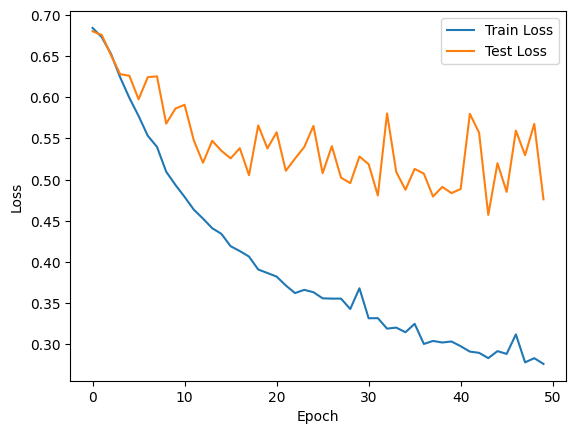

In [80]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
from sklearn.metrics import roc_auc_score, confusion_matrix

def evaluate(trained_model, dataloader):
  trained_model.eval()

  y_pred = []
  y_true = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      outputs = trained_model(inputs.float())
      predicted = (outputs.squeeze() > 0.5).long()
      y_pred.extend(predicted.tolist())
      y_true.extend(labels.tolist())

  accuracy = 100 * sum([1 if y_pred[i]==y_true[i] else 0 for i in range(len(y_pred))]) / len(y_pred)
  roc_auc = roc_auc_score(y_true, y_pred)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  specificity = tn / (tn + fp)
  sensitivity = tp / (tp + fn)

  return accuracy, roc_auc, specificity, sensitivity

In [82]:
def print_metrics(trained_model, dataloader, name):
  accuracy, roc_auc, specificity, sensitivity = evaluate(trained_model, dataloader)
  print(f"""{name} Metrics:
  Accuracy: {accuracy:.2f}%
  ROC AUC: {roc_auc:.4f}
  Specificity: {specificity:.4f}
  Sensitivity: {sensitivity:.4f}""")


In [83]:
# Best train model
print_metrics(best_train_model, train_loader, "Best Train Model on Training Data")
print_metrics(best_train_model, test_loader, "Best Train Model on Test Data")
# Best test model on loss
print_metrics(best_test_model_on_loss, train_loader, "Best Test Model on Loss on Training Data")
print_metrics(best_test_model_on_loss, test_loader, "Best Test Model on Loss on Test Data")
# Best test model on accuracy
print_metrics(best_test_model_on_accuracy, train_loader, "Best Test Model on Accuracy on Training Data")
print_metrics(best_test_model_on_accuracy, test_loader, "Best Test Model on Accuracy on Test Data")


Best Train Model on Training Data Metrics:
  Accuracy: 90.20%
  ROC AUC: 0.9020
  Specificity: 0.9198
  Sensitivity: 0.8841
Best Train Model on Test Data Metrics:
  Accuracy: 81.56%
  ROC AUC: 0.8156
  Specificity: 0.7821
  Sensitivity: 0.8491
Best Test Model on Loss on Training Data Metrics:
  Accuracy: 90.20%
  ROC AUC: 0.9020
  Specificity: 0.9198
  Sensitivity: 0.8841
Best Test Model on Loss on Test Data Metrics:
  Accuracy: 81.56%
  ROC AUC: 0.8156
  Specificity: 0.7821
  Sensitivity: 0.8491
Best Test Model on Accuracy on Training Data Metrics:
  Accuracy: 90.20%
  ROC AUC: 0.9020
  Specificity: 0.9198
  Sensitivity: 0.8841
Best Test Model on Accuracy on Test Data Metrics:
  Accuracy: 81.56%
  ROC AUC: 0.8156
  Specificity: 0.7821
  Sensitivity: 0.8491
